In [ ]:

# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Importation des bibliothèques nécessaires

In [ ]:
#import face_recognition
from sklearn.svm import SVC,LinearSVC
# from typing import List
# from PIL import Image
# from sklearn.model_selection import train_test_split
# from skimage import io
from skimage.color import rgb2gray
# from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore') 
import cv2
import os
import numpy as np
import dlib
import matplotlib.pyplot as plt

from skimage.transform import resize
import math
from skimage.feature import hog
from tqdm import tqdm
import pandas as pd

# Récupération des liens des images et leurs labels

In [ ]:

def _get_data(path):
    class_names = os.listdir(path)
    image_paths = []
    labels = []
    for name in class_names:
        directory = os.path.join(path, name)
        #directory = path + "/" + name
        #print(directory)
        class_path = [os.path.join(directory, f) for f in os.listdir(directory)]
        #class_path = [directory + "/" + f for f in os.listdir(directory)]
        image_paths += class_path
        labels.extend([name] * len(class_path))
    return image_paths, labels




def get_training_data(path_train = '/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_train'):
    return _get_data(path_train)


def get_test_data(path_test = '/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_test'):
    return _get_data(path_test)

In [ ]:
path_faces_train, labels_train = get_training_data()

print('Nombres de liens de visages coupés: ', len(path_faces_train))
print('Nombres de labels: ', len(labels_train))


Nombres de liens de visages coupés:  1763
Nombres de labels:  1763


# Chargement des visages

In [ ]:
# faces_ilbp,labels_ilbp  = Visage_detect_cascade(faces_dlib,labels_dlib)


def Open_faces(imgs_paths, labels):
  imgs = []
  labs = []
  for k in tqdm(range(len(imgs_paths))):
    img = cv2.imread(imgs_paths[k])
   # print(img.shape)
    imgs.append(img)
    labs.append(labels[k])
  return imgs, labs   



In [ ]:
def Open_faces_cnn(imgs_paths, labels):
  imgs = []
  labs = []
  for k in tqdm(range(len(imgs_paths))):
    imgs.append(cv2.resize(cv2.imread(imgs_paths[k],0), (150,150)))
    labs.append(labels[k])
  return imgs, labs   


# 1. Train

In [ ]:
faces_train, labels_train = Open_faces(path_faces_train, labels_train)

print('Nombres de liens de visages coupés: ', len(faces_train))
print('Nombres de labels: ', len(labels_train))

100%|██████████| 1763/1763 [13:13<00:00,  2.22it/s]

Nombres de liens de visages coupés:  1763
Nombres de labels:  1763


In [ ]:
np.array(faces_train).shape

(1763,)

In [ ]:
len(np.unique(labels_train))

32

Nombre de faces détectées par ILBPcascade:  1763
Nombre de labels ILBPcascade:  1763


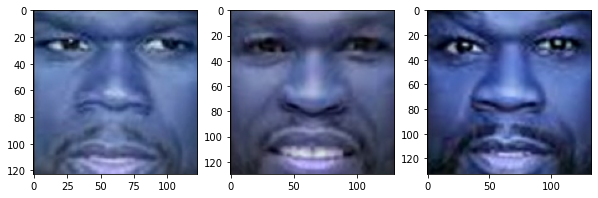

In [ ]:

print('Nombre de faces détectées par ILBPcascade: ', len(faces_train))
print('Nombre de labels ILBPcascade: ', len(labels_train))


i = 30
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_train[i])
plt.subplot(132)
plt.imshow(faces_train[i+1])
plt.subplot(133)
plt.imshow(faces_train[i+2])

# 2. Test

In [ ]:
path_faces_test, labels_test = get_test_data()

print('Nombres de liens de visages coupés: ', len(path_faces_test))
print('Nombres de labels: ', len(labels_test))

Nombres de liens de visages coupés:  630
Nombres de labels:  630


In [ ]:
np.unique(labels_test)

array(['50 Cent', 'Adam Baldwin', 'Amanda Righetti', 'Amanda Schull',
       'America Ferrera', 'Angelina Jolie', 'Assimi Goita', 'Aziz Ansari',
       'Boris Kodjoe', 'Dennis Haysbert', 'Denzel Washington',
       'Dwayne Johnson', 'Jackie Chan', 'Jet Li', 'Johnny Depp',
       'Katherine Heigl', 'Kerry Washington', 'Rihanna', 'Robin Tunney',
       'Sanogo', 'Sara Rafferty', 'Simon Baker', 'Stephen Amell',
       'Steve Jobs', 'Tim Kang', 'Vin Diesel', 'Viola Davis',
       'Vladimir Poutine', 'Wentworth Miller', 'Will Smith',
       'William Fichtner', 'Zachary Quinto'], dtype='<U17')

In [ ]:
faces_test, labels_test = Open_faces(path_faces_test, labels_test)

print('Nombres de liens de visages coupés: ', len(faces_test))
print('Nombres de labels: ', len(labels_test))

100%|██████████| 630/630 [05:21<00:00,  1.96it/s]

Nombres de liens de visages coupés:  630
Nombres de labels:  630


Nombre de faces détectées par ILBPcascade:  630
Nombre de labels ILBPcascade:  630


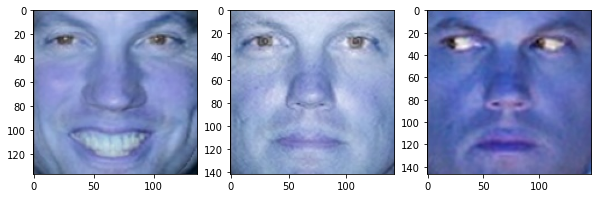

In [ ]:

print('Nombre de faces détectées par ILBPcascade: ', len(faces_test))
print('Nombre de labels ILBPcascade: ', len(labels_test))

i = 30
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_test[i])
plt.subplot(132)
plt.imshow(faces_test[i+1])
plt.subplot(133)
plt.imshow(faces_test[i+2])

# Extraction de caractéristiques HOG

In [ ]:

def Hog_feats(visages):
    # recadrer l'image
    features = []
    hog_img = []
 
    for i in tqdm(range(len(visages))):
         resized_img = resize(visages[i], (128, 64))
         fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)   
         features.append(fd)
         hog_img.append(hog_image) 
    return features,hog_img


# 1. Train

In [ ]:
features_train, hog_train = Hog_feats(faces_train)  

100%|██████████| 1763/1763 [00:40<00:00, 43.27it/s]


In [ ]:
np.array(features_train).shape

(1763, 3780)

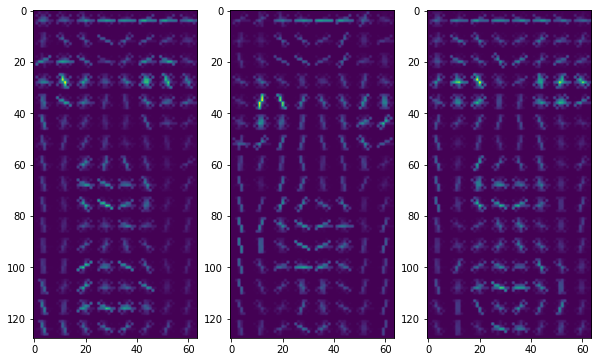

In [ ]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(hog_train[i])
plt.subplot(132)
plt.imshow(hog_train[i+1])
plt.subplot(133)
plt.imshow(hog_train[i+2])


# 2. Test

In [ ]:
features_test, hog_test = Hog_feats(faces_test) 


100%|██████████| 630/630 [00:15<00:00, 39.99it/s]


In [ ]:
np.array(features_test).shape

(630, 3780)

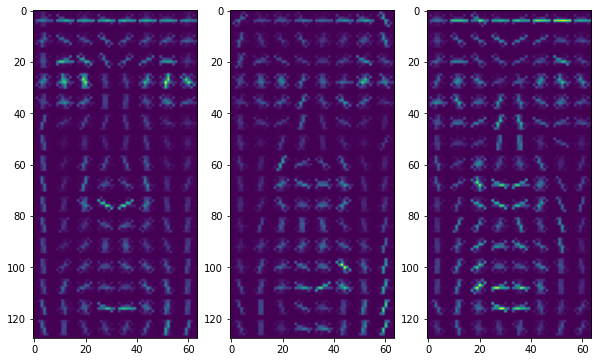

In [ ]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(hog_test[i])
plt.subplot(132)
plt.imshow(hog_test[i+1])
plt.subplot(133)
plt.imshow(hog_test[i+2])

In [ ]:


# data_train = pd.DataFrame(features_train)
# data_train["3780"] = labels_train
# data_train

In [ ]:
# data_train.to_excel('/content/drive/MyDrive/Projet S2/features_hog/train.xlsx')


In [ ]:

# data_test = pd.DataFrame(features_test)
# data_test["3780"] = labels_test
# data_test


In [ ]:
# data_test.to_excel('/content/drive/MyDrive/Projet S2/features_hog/test.xlsx')


In [ ]:
import pandas as pd
features_train = pd.read_excel('/content/drive/MyDrive/Projet S2/features_hog/train.xlsx')
features_train


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780
0,0,0.118537,0.256241,0.133531,0.259241,0.259241,0.093071,0.259241,0.259241,0.116999,...,0.302123,0.302123,0.163748,0.065095,0.127561,0.031643,0.005335,0.044429,0.206510,50 Cent
1,1,0.071662,0.185745,0.104361,0.295770,0.295770,0.000000,0.000000,0.000000,0.000000,...,0.359684,0.052287,0.000000,0.000000,0.053571,0.000000,0.000000,0.000000,0.021079,50 Cent
2,2,0.222330,0.158640,0.142007,0.233105,0.306891,0.048202,0.052651,0.175960,0.208401,...,0.320327,0.244777,0.096213,0.082696,0.114201,0.050622,0.026768,0.055819,0.060295,50 Cent
3,3,0.346858,0.052376,0.038721,0.224295,0.346858,0.088347,0.046046,0.069354,0.103065,...,0.013290,0.007715,0.003484,0.004052,0.037349,0.010060,0.003355,0.007999,0.006009,50 Cent
4,4,0.054778,0.091617,0.024894,0.287691,0.287691,0.105902,0.098754,0.199300,0.000000,...,0.302757,0.194790,0.039649,0.027942,0.148285,0.011439,0.080187,0.072891,0.108765,50 Cent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1758,0.067823,0.027469,0.039466,0.192184,0.381022,0.107606,0.252344,0.058777,0.071142,...,0.330010,0.330010,0.049950,0.030354,0.106479,0.026339,0.053010,0.064507,0.122032,Zachary Quinto
1759,1759,0.352758,0.074290,0.019331,0.143025,0.352758,0.013626,0.009943,0.032449,0.147505,...,0.330431,0.330431,0.067312,0.018144,0.097350,0.010730,0.000000,0.015600,0.101931,Zachary Quinto
1760,1760,0.164170,0.058427,0.029725,0.319222,0.260665,0.059881,0.319222,0.110561,0.199669,...,0.341110,0.341110,0.018994,0.000000,0.051844,0.000000,0.000000,0.007703,0.032298,Zachary Quinto
1761,1761,0.207311,0.312520,0.312520,0.312520,0.312520,0.000000,0.000000,0.063894,0.073512,...,0.184903,0.022073,0.000000,0.037164,0.093285,0.039966,0.037970,0.294581,0.143961,Zachary Quinto


In [ ]:
data_train = features_train[features_train.columns[1:-1]]
data_train

,0,1,2,3,4,5,6,7,8,9,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,0.118537,0.256241,0.133531,0.259241,0.259241,0.093071,0.259241,0.259241,0.116999,0.066455,...,0.096377,0.302123,0.302123,0.163748,0.065095,0.127561,0.031643,0.005335,0.044429,0.206510
1,0.071662,0.185745,0.104361,0.295770,0.295770,0.000000,0.000000,0.000000,0.000000,0.189072,...,0.359684,0.359684,0.052287,0.000000,0.000000,0.053571,0.000000,0.000000,0.000000,0.021079
2,0.222330,0.158640,0.142007,0.233105,0.306891,0.048202,0.052651,0.175960,0.208401,0.099926,...,0.319670,0.320327,0.244777,0.096213,0.082696,0.114201,0.050622,0.026768,0.055819,0.060295
3,0.346858,0.052376,0.038721,0.224295,0.346858,0.088347,0.046046,0.069354,0.103065,0.098647,...,0.405539,0.013290,0.007715,0.003484,0.004052,0.037349,0.010060,0.003355,0.007999,0.006009
4,0.054778,0.091617,0.024894,0.287691,0.287691,0.105902,0.098754,0.199300,0.000000,0.215534,...,0.302757,0.302757,0.194790,0.039649,0.027942,0.148285,0.011439,0.080187,0.072891,0.108765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,0.067823,0.027469,0.039466,0.192184,0.381022,0.107606,0.252344,0.058777,0.071142,0.006965,...,0.055402,0.330010,0.330010,0.049950,0.030354,0.106479,0.026339,0.053010,0.064507,0.122032
1759,0.352758,0.074290,0.019331,0.143025,0.352758,0.013626,0.009943,0.032449,0.147505,0.016133,...,0.126499,0.330431,0.330431,0.067312,0.018144,0.097350,0.010730,0.000000,0.015600,0.101931
1760,0.164170,0.058427,0.029725,0.319222,0.260665,0.059881,0.319222,0.110561,0.199669,0.041013,...,0.006604,0.341110,0.341110,0.018994,0.000000,0.051844,0.000000,0.000000,0.007703,0.032298
1761,0.207311,0.312520,0.312520,0.312520,0.312520,0.000000,0.000000,0.063894,0.073512,0.007835,...,0.362652,0.184903,0.022073,0.000000,0.037164,0.093285,0.039966,0.037970,0.294581,0.143961


In [ ]:
yy_train = features_train['3780']
yy_train

0              50 Cent
1              50 Cent
2              50 Cent
3              50 Cent
4              50 Cent
             ...      
1758    Zachary Quinto
1759    Zachary Quinto
1760    Zachary Quinto
1761    Zachary Quinto
1762    Zachary Quinto
Name: 3780, Length: 1763, dtype: object

In [ ]:
features_test = pd.read_excel('/content/drive/MyDrive/Projet S2/features_hog/test.xlsx')
features_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780
0,0,0.204586,0.025891,0.157875,0.142713,0.331028,0.024769,0.051876,0.017241,0.262228,...,0.350654,0.250765,0.014244,0.000000,0.042854,0.000000,0.004646,0.008754,0.064923,50 Cent
1,1,0.198342,0.338179,0.338179,0.087425,0.115531,0.033780,0.048257,0.017462,0.012661,...,0.331176,0.331176,0.113437,0.007332,0.002838,0.000000,0.003811,0.000000,0.014711,50 Cent
2,2,0.067038,0.077124,0.000000,0.277693,0.383779,0.159803,0.145535,0.047189,0.122905,...,0.290070,0.290070,0.290070,0.014681,0.144818,0.005681,0.000000,0.024653,0.057613,50 Cent
3,3,0.258128,0.149139,0.000000,0.188933,0.258128,0.140218,0.210300,0.258128,0.161490,...,0.284769,0.066598,0.084265,0.107732,0.048610,0.000000,0.017430,0.145484,0.284769,50 Cent
4,4,0.136261,0.128361,0.138661,0.317940,0.294295,0.051424,0.239164,0.137175,0.029834,...,0.190857,0.065655,0.015002,0.017137,0.057936,0.026497,0.068535,0.076838,0.115039,50 Cent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,625,0.268603,0.024236,0.029957,0.172508,0.356338,0.027276,0.003731,0.000000,0.122547,...,0.295796,0.295796,0.135863,0.060809,0.129627,0.015105,0.015173,0.042972,0.120288,Zachary Quinto
626,626,0.045485,0.000000,0.091179,0.174120,0.381826,0.108187,0.077352,0.019799,0.043544,...,0.407657,0.407657,0.020563,0.000000,0.094355,0.025805,0.008986,0.276229,0.407657,Zachary Quinto
627,627,0.204163,0.010352,0.183713,0.296964,0.296964,0.043407,0.032951,0.022403,0.036581,...,0.414037,0.414037,0.057124,0.030397,0.089848,0.000000,0.000000,0.000000,0.147318,Zachary Quinto
628,628,0.051055,0.000000,0.095374,0.164541,0.350245,0.234125,0.218722,0.072952,0.179780,...,0.389686,0.389686,0.105987,0.000000,0.067059,0.000000,0.000000,0.036895,0.064960,Zachary Quinto


In [ ]:
data_test = features_test[features_test.columns[1:-1]]
data_test

,0,1,2,3,4,5,6,7,8,9,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,0.204586,0.025891,0.157875,0.142713,0.331028,0.024769,0.051876,0.017241,0.262228,0.033184,...,0.266878,0.350654,0.250765,0.014244,0.000000,0.042854,0.000000,0.004646,0.008754,0.064923
1,0.198342,0.338179,0.338179,0.087425,0.115531,0.033780,0.048257,0.017462,0.012661,0.012727,...,0.331176,0.331176,0.331176,0.113437,0.007332,0.002838,0.000000,0.003811,0.000000,0.014711
2,0.067038,0.077124,0.000000,0.277693,0.383779,0.159803,0.145535,0.047189,0.122905,0.014212,...,0.290070,0.290070,0.290070,0.290070,0.014681,0.144818,0.005681,0.000000,0.024653,0.057613
3,0.258128,0.149139,0.000000,0.188933,0.258128,0.140218,0.210300,0.258128,0.161490,0.233371,...,0.284769,0.284769,0.066598,0.084265,0.107732,0.048610,0.000000,0.017430,0.145484,0.284769
4,0.136261,0.128361,0.138661,0.317940,0.294295,0.051424,0.239164,0.137175,0.029834,0.016122,...,0.368519,0.190857,0.065655,0.015002,0.017137,0.057936,0.026497,0.068535,0.076838,0.115039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.268603,0.024236,0.029957,0.172508,0.356338,0.027276,0.003731,0.000000,0.122547,0.017106,...,0.106068,0.295796,0.295796,0.135863,0.060809,0.129627,0.015105,0.015173,0.042972,0.120288
626,0.045485,0.000000,0.091179,0.174120,0.381826,0.108187,0.077352,0.019799,0.043544,0.013264,...,0.128154,0.407657,0.407657,0.020563,0.000000,0.094355,0.025805,0.008986,0.276229,0.407657
627,0.204163,0.010352,0.183713,0.296964,0.296964,0.043407,0.032951,0.022403,0.036581,0.004704,...,0.076206,0.414037,0.414037,0.057124,0.030397,0.089848,0.000000,0.000000,0.000000,0.147318
628,0.051055,0.000000,0.095374,0.164541,0.350245,0.234125,0.218722,0.072952,0.179780,0.003654,...,0.094824,0.389686,0.389686,0.105987,0.000000,0.067059,0.000000,0.000000,0.036895,0.064960


In [ ]:
yy_test = features_test['3780']
yy_test

0             50 Cent
1             50 Cent
2             50 Cent
3             50 Cent
4             50 Cent
            ...      
625    Zachary Quinto
626    Zachary Quinto
627    Zachary Quinto
628    Zachary Quinto
629    Zachary Quinto
Name: 3780, Length: 630, dtype: object

# Models MLP

In [ ]:
# X_train = data_train.copy()
# y_train = yy_train.copy()


X_train = np.array(features_train).copy()
y_train = np.array(labels_train).copy()

In [ ]:
X_train.shape

(1763, 3780)

In [ ]:
# X_test = data_test.copy()
# y_test = yy_test.copy()



X_test = np.array(features_test).copy()
y_test = np.array(labels_test).copy()

In [ ]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import numpy as np
lb = LabelEncoder()

# lb.fit(labels_train)
# y_train_one_hot = lb.transform(labels_train)

lb.fit(y_train)
y_train_one_hot = lb.transform(y_train)


y_train_one_hot

array([ 0,  0,  0, ..., 31, 31, 31])

In [ ]:
lab = lb.inverse_transform(np.array([y_train_one_hot[10]]))
lab

array(['50 Cent'], dtype='<U17')

In [ ]:


# lb.fit(labels_test)
# y_test_one_hot = lb.transform(labels_test)


lb.fit(y_test)
y_test_one_hot = lb.transform(y_test)


y_test_one_hot.shape

(630,)

In [ ]:
import tensorflow as tf

#  First model ANN-MLP

# n_classes = len(np.unique(labels_train))

n_classes = len(np.unique(y_train))



mlp = tf.keras.models.Sequential(layers = [
    #tf.keras.layers.Input(X_train.shape),
    tf.keras.layers.Dense(1000, activation = 'tanh'),
   tf.keras.layers.Dense(800, activation = 'tanh'),
   tf.keras.layers.Dense(600, activation = 'tanh'),
 #  tf.keras.layers.Dense(400, activation = 'tanh'),
#   tf.keras.layers.Dense(200, activation = 'tanh'),
   tf.keras.layers.Dense(100, activation = 'tanh'),
    tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(n_classes, activation = 'softmax')
])



In [ ]:
n_classes

32

In [ ]:



# mlp.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
# loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
# metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
from tensorflow.python.ops.array_ops import batch_gather
# hist = mlp.fit(np.array(features_train), y_train_one_hot,epochs=100, validation_data= (np.array(features_test), y_test_one_hot ) )


mlp.compile( optimizer = 'sgd',
           loss = 'sparse_categorical_crossentropy',
           metrics = ['accuracy'])
hist = mlp.fit(X_train, y_train_one_hot,epochs=200, validation_data= (X_test, y_test_one_hot ) )



Epoch 1/200
56/56 [==============================] - 2s 23ms/step - loss: 3.3824 - accuracy: 0.0754 - val_loss: 3.2146 - val_accuracy: 0.0905
Epoch 2/200
56/56 [==============================] - 1s 20ms/step - loss: 2.9913 - accuracy: 0.2609 - val_loss: 2.9462 - val_accuracy: 0.1937
Epoch 3/200
56/56 [==============================] - 1s 19ms/step - loss: 2.6236 - accuracy: 0.4124 - val_loss: 2.5459 - val_accuracy: 0.3349
Epoch 4/200
56/56 [==============================] - 1s 19ms/step - loss: 2.2978 - accuracy: 0.5315 - val_loss: 2.1938 - val_accuracy: 0.5492
Epoch 5/200
56/56 [==============================] - 1s 21ms/step - loss: 2.0018 - accuracy: 0.6166 - val_loss: 2.0012 - val_accuracy: 0.5921
Epoch 6/200
56/56 [==============================] - 1s 19ms/step - loss: 1.7913 - accuracy: 0.6716 - val_loss: 1.7262 - val_accuracy: 0.7317
Epoch 7/200
56/56 [==============================] - 1s 19ms/step - loss: 1.5696 - accuracy: 0.7289 - val_loss: 1.5479 - val_accuracy: 0.7556
Epoch 

In [ ]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              3781000   
                                                                 
 dense_1 (Dense)             (None, 800)               800800    
                                                                 
 dense_2 (Dense)             (None, 600)               480600    
                                                                 
 dense_3 (Dense)             (None, 100)               60100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
Total params: 5,125,732
Trainable params: 5,125,732
Non-

In [ ]:
# mlp.evaluate(np.array(features_test), y_test_one_hot)

mlp.evaluate(X_test, y_test_one_hot)


20/20 [==============================] - 0s 8ms/step - loss: 0.1577 - accuracy: 0.9619


[0.157749742269516, 0.961904764175415]

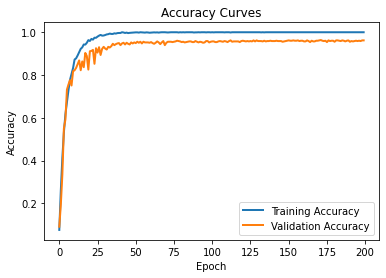

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize= (10,6))
# plt.subplot(1, 2, 1)
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Training Accuracy',
#            'Validation Accuracy'])
# plt.title('Accuracy Curves')


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(hist.history['accuracy'] ,lw=2)
ax.plot(hist.history['val_accuracy'],lw=2)


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')


# save plot to file
fig.savefig('plot.png')




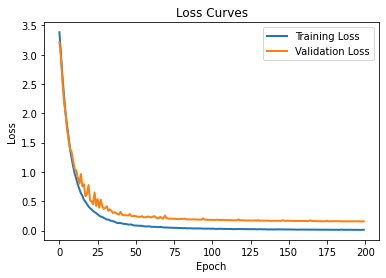

In [ ]:



fig = plt.figure()
ax = plt.subplot(111)
ax.plot(hist.history['loss'] ,lw=2)
ax.plot(hist.history['val_loss'],lw=2)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

# save plot to file
fig.savefig('plot.png')


In [ ]:
from sklearn.metrics  import classification_report, confusion_matrix


# print(classification_report(predictions, y_test_one_hot))

# predictions = np.argmax(mlp.predict(np.array(features_test)), axis=-1)


predictions = np.argmax(mlp.predict(X_test), axis=-1)

In [ ]:
cm = confusion_matrix(y_test_one_hot, predictions)

Confusion matrix for HOG + MLP NN


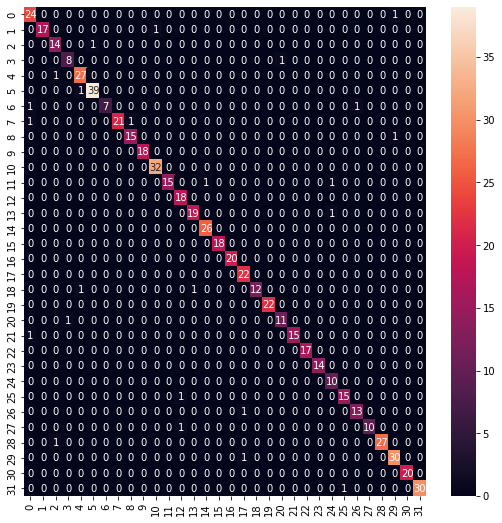

In [ ]:
import seaborn as sns

print("Confusion matrix for HOG + MLP NN")
plt.figure(figsize= (9, 9))
sns.heatmap(cm, annot=True)
plt.savefig('filename.png')

# Prédiction

In [ ]:
face_pat, label = _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/faces_ilbp_testt/test')
face, label = Open_faces(face_pat, label)
plt.imshow(face[0])

In [ ]:
feature,jj = Hog_feats(face)

In [ ]:
prediction = np.argmax(mlp.predict(np.array(feature)), axis=-1)

In [ ]:
label_predict = lb.inverse_transform(prediction)

In [ ]:
label_predict

In [ ]:
# from sklearn.neural_network import MLPClassifier


In [ ]:
# clf = MLPClassifier( hidden_layer_sizes = (100, 100, n_classes), activation= 'relu', max_iter = 100)


In [ ]:
# clf.fit(np.array(features_train), y_train_one_hot)


In [ ]:
# y_pred = clf.predict(np.array(features_test))

In [ ]:
# from sklearn.metrics  import accuracy_score



In [ ]:
# from sklearn.model_selection import GridSearchCV

# # defining parameter range
# tuned_parameters = {'hidden_layer_sizes':[(20,10, n_classes),(40,30, n_classes),(60,50, n_classes),(80,70, n_classes),(100,100, n_classes), (100,100,100, n_classes), (100,100,100,100, n_classes)],
#                     # 'alpha':   [0.001, 0.01, 1, 2],
#                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#                     'solver': ['lbfgs', 'sgd', 'ada m'],
#                     'learning_rate_init': [0.1, 0.01, 0.001, 0.0001,1],
#                     }

# grid = clf = GridSearchCV(MLPClassifier(), tuned_parameters,scoring = 'accuracy', cv = 5)
# # fitting the model for grid search
# grid.fit(X_train, y_train_one_hot)


In [ ]:
# mod = grid.best_estimator_
# mod

In [ ]:
# predit = mod.predict(X_test)

In [ ]:
# accuracy_score(y_test_one_hot, predit)

In [ ]:
# from sklearn.datasets import fetch_lfw_people

In [ ]:
# lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)
